In [1]:
import sys
import os
import numpy as np
import multiprocessing
import dill
import matplotlib.pyplot as plt
import pandas as pd

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path + "/src/simulations_v2")
from load_params import load_params

from multi_group_simulation_lockdown import MultiGroupSimulation

In [2]:
def run_multigroup_sim(sim, T):
    sim.run_new_trajectory(T)
    list_dfs = list()
    for sim_group in sim.sims:
        list_dfs.append(sim_group.sim_df)
    return list_dfs

def run_multiple_trajectories(sim, T, n):
    sim_results = list()
    for _ in range(n):
        result = run_multigroup_sim(sim, T)
        sim_results.append(result)
    return sim_results

def evaluate_testing_policy(params_list, interaction_matrix, group_names, test_frac, T, n):
    assert len(params_list) == len(test_frac)
    
    group_size = list()
    tests_per_day = 0
    
    # set group based contacts per day, test frequency
    for index, params in enumerate(params_list):
        params['expected_contacts_per_day'] = interaction_matrix[index, index]
        params['test_population_fraction'] = test_frac[index]
        group_size.append(params['population_size'])
        tests_per_day += group_size[-1] * test_frac[index]
    
    assert len(group_size) == len(test_frac)
    
    sim = MultiGroupSimulation(params_list, interaction_matrix, group_names)
    sim_results = run_multiple_trajectories(sim, T, n)
    return tests_per_day, sim_results

### August 28 - Sept 1 cases

In [4]:
def sample_pre_sim_cases():
    pre_sim_cases = list()
    pre_sim_cases.append(9) # August 28
    pre_sim_cases.append(2) # August 29
    pre_sim_cases.append(1) # August 30
    pre_sim_cases.append(5) # August 31
    pre_sim_cases.append(7) # Sept 1
    return pre_sim_cases

### Sim Cases

In [4]:
base_directory = '../src/simulations_v2/params/baseline_testing/aug_29_NY_lockdown/nominal/'

ug_dorm_params = load_params(base_directory + 'ug_dorm.yaml')[1]
ug_off_campus_params = load_params(base_directory + 'ug_off_campus.yaml')[1]
gs_research_params = load_params(base_directory + 'grad_research.yaml')[1]
gs_other_params = load_params(base_directory + 'grad_other.yaml')[1]
faculty_staff_student_params = load_params(base_directory + 'faculty_staff_student_same_age.yaml')[1]
faculty_staff_non_student_params = load_params(base_directory + 'faculty_staff_non_student_same_age.yaml')[1]
faculty_staff_off_campus_params = load_params(base_directory + 'faculty_staff_off_campus_same_age.yaml')[1]
ithaca_community_params = load_params(base_directory + 'ithaca_community.yaml')[1]

/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


In [5]:
# Vet school: 300 students
gs_other_params['population_size'] = gs_other_params['population_size'] - 300

In [6]:
policy = [2/7,2/7,1/7,2/7,2/7,1/7,1/30,0]
interaction_matrix = np.array([[12.5,4,0.1,0.1,1,0.05,0.05,0.1],
                               [3.41,8,0.1,0.1,1,0.05,0.05,0.2],
                               [0.19,0.22,4,0.1,1.2,0.05,0.2,1.8],
                               [0.14,0.17,0.07,9,1,0.05,0.05,0.2],
                               [1.92,2.26,1.22,1.37,1,0.15,0.3,1.56],
                               [0.18,0.21,0.1,0.13,0.28,1.8,0.2,1.56],
                               [0.07,0.09,0.15,0.05,0.23,0.08,1.8,1.56],
                               [0.011,0.026,0.106,0.016,0.091,0.048,0.12,3.5]])

group_names = ['UG (campus)', 'UG (off campus)', 'GS (research)', 'GS (other)', 'Faculty/Staff (student facing)', 'Faculty/Staff (non student facing)', 'Faculty/Staff (off campus)', 'Ithaca Community']

In [7]:
params_list = [ug_dorm_params.copy(), ug_off_campus_params.copy(), gs_research_params.copy(), gs_other_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
tests_per_day_nominal, sim_results_nominal = evaluate_testing_policy(params_list, interaction_matrix, group_names, policy, 84, 50)

In [ ]:
# Finding list of new found cases per day

# Simulate number of FPs per day


In [8]:
print(sim_results_nominal[0][1])
# print(sim_results_nominal[0][0][['cumulative_mild','cumulative_severe','SyID_mild','new_real_cases','new_cases']])
print(np.cumsum(sim_results_nominal[0][1]['new_real_cases']), np.cumsum(sim_results_nominal[0][0]['new_cases']))
print(sim_results_nominal[0][1].missed_cases)

       S  QS  QI   R E_0 E_1 E_2 E_3 E_4 E_5  ... cumulative_mild  \
0   7622   0   0   0   0   0   0   0   0   0  ...               0   
1   7619   0   1   1   2   0   0   0   0   0  ...               3   
2   7612   6   4   2   0   0   0   0   1   0  ...               7   
3   7596  18   9   3   0   1   0   0   0   0  ...               9   
4   7589  25   9   5   0   0   0   0   0   0  ...              12   
..   ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...             ...   
80  7521  15  12  74   3   1   2   2   0   0  ...              49   
81  7508  24  15  75   1   4   2   0   0   0  ...              50   
82  7503  26  17  75   5   2   0   0   0   0  ...              51   
83  7498  30  16  78   2   1   0   0   0   0  ...              53   
84  7494  33  18  80   2   0   0   0   0   0  ...              53   

   cumulative_severe cumulative_outside_infections new_real_cases new_cases  \
0                  0                             0              0         0   
1            

In [9]:
sim_results_nominal[0][1].to_csv('Aug_29_sim_df.csv')

In [8]:
def get_total_new_cases(sim_dfs, include_array):
    assert len(sim_dfs) == len(include_array)
    if include_array[0] == True:
        cases = np.array(sim_dfs[0]['new_cases'])
    else:
        cases = np.array(sim_dfs[0]['new_cases']) - np.array(sim_dfs[0]['new_cases'])
    for i in range(1, len(sim_dfs)):
        if include_array[i] == True:
            cases += np.array(sim_dfs[i]['new_cases'])
    return cases

In [9]:
cornell_case_counts = list()
student_case_counts = list()
for sim_dfs in sim_results_nominal:
    pre_sim_cases = sample_pre_sim_cases()
    student_case_counts.append(np.concatenate([np.array(pre_sim_cases), np.array(get_total_new_cases(sim_dfs, [True, True, True, True, False, False, False, False]))]))
    cornell_case_counts.append(np.concatenate([np.array(pre_sim_cases), np.array(get_total_new_cases(sim_dfs, [True, True, True, True, True, True, True, False]))]))

Text(0.5, 0, 'Day')

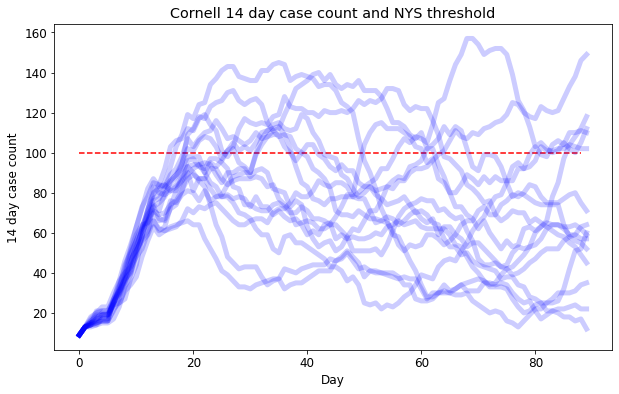

In [11]:
plt.figure(figsize=(10,6))
for new_case_trajectory in cornell_case_counts[:15]:
    window_case_trajectory = new_case_trajectory.cumsum()
    window_case_trajectory[14:] = window_case_trajectory[14:] - window_case_trajectory[:-14]
    plt.plot(window_case_trajectory, color='blue', alpha=0.2, linewidth=5)
plt.hlines(100, 0, 88, colors='red', linestyles='dashed')
plt.title('Cornell 14 day case count and NYS threshold')
plt.ylabel('14 day case count')
plt.xlabel('Day')

In [35]:
lockdown_occured = 0
trajectory = 0
# 14 day cumulative trajectory
for new_case_trajectory in cornell_case_counts:
    window_case_trajectory = new_case_trajectory.cumsum()
    window_case_trajectory[14:] = window_case_trajectory[14:] - window_case_trajectory[:-14]

#     print(window_case_trajectory)
    
    if np.sum(np.array(window_case_trajectory)>100) > 0: # There is a 14 day window with > 100 cases
        lockdown_occured += 1
    else:
        print(window_case_trajectory)
    trajectory += 1
print(lockdown_occured / trajectory)

[9 13 13 18 21 21 25 31 39 45 55 64 70 76 74 76 84 84 85 90 90 87 80 78 73
 70 66 65 61 60 54 54 51 50 47 45 52 57 56 54 58 55 55 54 53 48 52 50 53
 57 52 48 47 45 41 40 41 42 45 51 51 55 58 58 64 62 64 69 71 74 71 71 68
 67 67 67 67 69 60 61 63 61 61 65 69 67 71 73 72 69]
[9 13 16 21 22 22 28 31 41 50 59 71 77 85 79 78 80 79 81 85 86 92 89 90 87
 78 77 78 81 82 85 89 92 96 96 98 97 92 88 94 97 98 96 97 93 90 91 86 80
 73 73 69 72 67 65 57 57 53 52 49 43 42 44 41 38 39 36 34 29 31 28 32 36
 36 36 35 32 31 29 32 32 30 30 29 28 27 21 22 23 26]
[9 13 16 17 17 17 24 29 37 47 58 62 68 72 67 71 75 81 85 91 91 89 85 77 77
 86 86 92 94 91 89 86 88 87 85 88 91 96 92 87 83 76 72 71 68 67 65 64 63
 58 54 51 45 39 41 40 38 37 40 39 36 33 33 33 33 32 35 37 33 34 36 34 32
 32 38 40 37 37 37 36 34 31 33 32 32 32 32 32 28 26]
[9 13 15 16 16 16 27 33 41 51 58 65 69 73 66 65 65 67 67 73 66 64 63 56 56
 53 55 59 66 69 78 84 94 91 89 92 89 89 86 87 86 84 77 76 71 68 62 65 65
 59 59 58 54 50 46 42 41 37 36

Text(0.5, 0, 'Day')

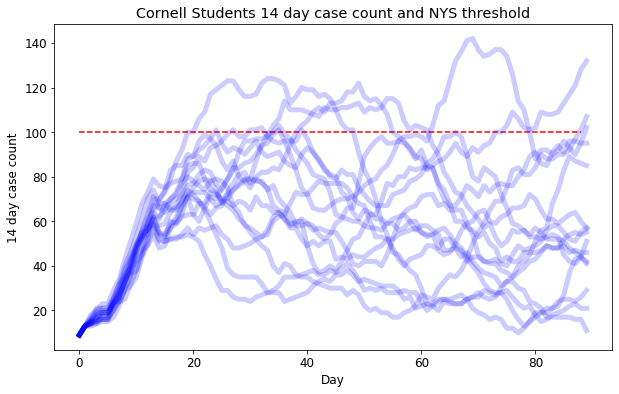

In [12]:
plt.figure(figsize=(10,6))
for new_case_trajectory in student_case_counts[:15]:
    window_case_trajectory = new_case_trajectory.cumsum()
    window_case_trajectory[14:] = window_case_trajectory[14:] - window_case_trajectory[:-14]
    plt.plot(window_case_trajectory, color='blue', alpha=0.2, linewidth=5)
plt.hlines(100, 0, 88, colors='red', linestyles='dashed')
plt.title('Cornell Students 14 day case count and NYS threshold')
plt.ylabel('14 day case count')
plt.xlabel('Day')

In [13]:
print(cornell_case_counts[0])
print(student_case_counts[0])

[9 4 5 2 1 0 6 7 8 10 11 9 10 5 5 5 2 2 8 5 3 3 5 1 1 3 0 2 2 6 2 2 3 1 5
 4 0 3 2 3 2 4 4 6 2 7 4 4 1 0 1 1 2 2 2 4 2 2 2 0 3 4 2 3 1 1 1 2 3 0 0 0
 0 1 2 0 1 1 4 4 4 2 6 0 1 6 10 10 3 8]
[9 4 5 2 1 0 5 6 8 6 7 8 9 4 3 4 2 2 5 5 3 3 4 1 1 2 0 1 2 4 2 2 2 1 3 3 0
 2 2 3 1 4 4 5 1 5 2 3 1 0 1 1 1 2 1 4 2 1 2 0 3 4 1 2 1 0 0 2 3 0 0 0 0 1
 2 0 1 0 3 3 4 2 5 0 1 5 10 7 3 7]


### Breakdown of Cases

In [14]:
def get_case_breakdown(sim_dfs, include_array):
    assert len(sim_dfs) == len(include_array)
    if include_array[0] == True:
        cases = np.array(sim_dfs[0]['new_cases'])
        real_cases = np.array(sim_dfs[0]['new_real_cases'])
        missed_cases = np.array(sim_dfs[0]['missed_cases'])
    else:
        cases = np.array(sim_dfs[0]['new_cases']) - np.array(sim_dfs[0]['new_cases'])
        real_cases = np.array(sim_dfs[0]['new_real_cases']) - np.array(sim_dfs[0]['new_real_cases'])
        missed_cases = np.array(sim_dfs[0]['missed_cases']) - np.array(sim_dfs[0]['missed_cases'])
    for i in range(1, len(sim_dfs)):
        if include_array[i] == True:
            cases += np.array(sim_dfs[i]['new_cases'])
            real_cases += np.array(sim_dfs[i]['new_real_cases'])
            missed_cases += np.array(sim_dfs[i]['missed_cases'])
    return np.sum(real_cases)/np.sum(cases), (np.sum(cases) - np.sum(real_cases))/np.sum(cases), missed_cases[-1]/np.sum(cases)

In [15]:
percent_real = list()
percent_FP = list()
percent_missed = list()

for sim_dfs in sim_results_nominal:
    real, FP, missed = get_case_breakdown(sim_dfs, [True, True, True, True, True, True, True, False])
    percent_real.append(real)
    percent_FP.append(FP)
    percent_missed.append(missed)

In [16]:
labels = ['Real', 'False Positive', 'Missed']
y = [np.median(percent_real), np.median(percent_FP), np.median(percent_missed)]
y_err_low = [np.quantile(percent_real, 0.5) - np.quantile(percent_real, 0.1), np.quantile(percent_FP, 0.5) - np.quantile(percent_FP, 0.1), np.quantile(percent_missed, 0.5) - np.quantile(percent_missed, 0.1)]
y_err_high = [np.quantile(percent_real, 0.9) - np.quantile(percent_real, 0.5), np.quantile(percent_FP, 0.9) - np.quantile(percent_FP, 0.5), np.quantile(percent_missed, 0.9) - np.quantile(percent_missed, 0.5)]

plotting_df = pd.DataFrame({'label': labels, 'y':y, 'y_err_low': y_err_low, 'y_err_high': y_err_high})

Text(0, 0.5, 'Percent of total cases')

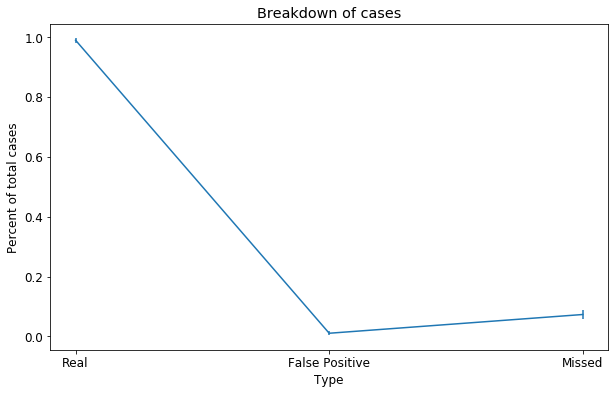

In [17]:
plt.figure(figsize=(10,6))
plt.errorbar(x='label', y='y', yerr=[plotting_df['y_err_low'], plotting_df['y_err_high']], data=plotting_df)
plt.title('Breakdown of cases')
plt.xlabel('Type')
plt.ylabel('Percent of total cases')

In [18]:
np.median(percent_real), np.median(percent_FP)

(0.9893341702257334, 0.010665829774266469)

In [19]:
def get_cases_by_class(sim_dfs):
    total_cases = 0
    for sim_df in sim_dfs:
        total_cases += np.sum(sim_df['new_cases'])
    return_array = list()
    for sim_df in sim_dfs:
        return_array.append(np.sum(sim_df['new_cases'])/total_cases)
    return return_array

In [20]:
ug_high_percent = list()
ug_low_percent = list()
gs_research_percent = list()
gs_class_percent = list()
fs_student_percent = list()
fs_non_student_percent = list()
fs_off_percent = list()
ithaca_percent = list()

for sim_dfs in sim_results_nominal:
    breakdown = get_cases_by_class(sim_dfs)
    ug_high_percent.append(breakdown[0])
    ug_low_percent.append(breakdown[1])
    gs_research_percent.append(breakdown[2])
    gs_class_percent.append(breakdown[3])
    fs_student_percent.append(breakdown[4])
    fs_non_student_percent.append(breakdown[5])
    fs_off_percent.append(breakdown[6])
    ithaca_percent.append(breakdown[7])

In [21]:
def generate_plotting_data(list_values):
    y = list()
    y_err_low = list()
    y_err_high = list()
    for array in list_values:
        y.append(np.median(array))
        y_err_low.append(np.quantile(array, 0.5) - np.quantile(array, 0.1))
        y_err_high.append(np.quantile(array, 0.9) - np.quantile(array, 0.5))
    return y, y_err_low, y_err_high

In [22]:
labels = ['UG high', 'UG low', 'GS research', 'GS class', 'FS student', 'FS non student', 'FS off', 'Ithaca']
y, y_err_low, y_err_high = generate_plotting_data([ug_high_percent, ug_low_percent, gs_research_percent, gs_class_percent, fs_student_percent, fs_non_student_percent, fs_off_percent, ithaca_percent])

plotting_df = pd.DataFrame({'label': labels, 'y':y, 'y_err_low': y_err_low, 'y_err_high': y_err_high})

Text(0, 0.5, 'Percent of total cases')

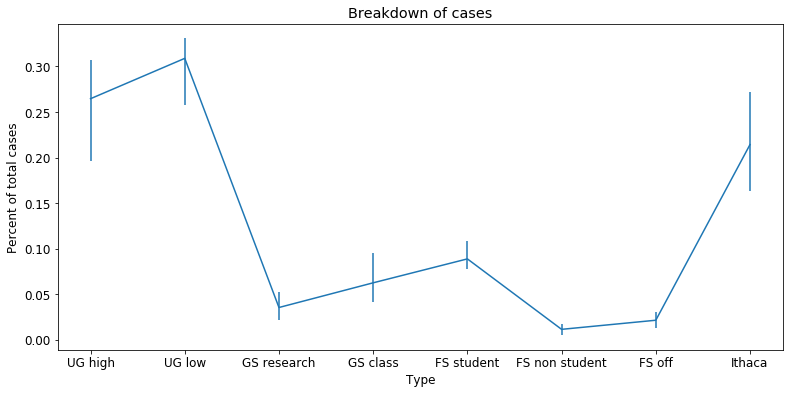

In [23]:
plt.figure(figsize=(13,6))
plt.errorbar(x='label', y='y', yerr=[plotting_df['y_err_low'], plotting_df['y_err_high']], data=plotting_df)
plt.title('Breakdown of cases')
plt.xlabel('Type')
plt.ylabel('Percent of total cases')

In [24]:
outside_infections_ithaca_array = list()
for sim_dfs in sim_results_nominal:
    outside_infections_ithaca_array.append(np.array(sim_dfs[-1]['cumulative_outside_infections'])[-1]/np.sum(sim_dfs[-1]['new_cases']))
np.quantile(outside_infections_ithaca_array, 0.1), np.median(outside_infections_ithaca_array), np.quantile(outside_infections_ithaca_array, 0.9)

(0.21066433566433568, 0.2597840755735492, 0.3132351934269086)

In [28]:
plotting_df

,label,y,y_err_low,y_err_high
0,UG high,0.225686,0.043693,0.035789
1,UG low,0.321136,0.017528,0.025589
2,GS research,0.047420,0.009962,0.012070
3,GS class,0.098604,0.015356,0.025487
4,FS student,0.121870,0.012509,0.010535
5,FS non student,0.026484,0.006988,0.006178
6,FS off,0.021935,0.004302,0.007191
7,Ithaca,0.126906,0.019124,0.031869


In [45]:
sim_results_nominal[0][0]['new_cases'] + sim_results_nominal[0][1]['new_cases'] + sim_results_nominal[0][2]['new_cases'] + sim_results_nominal[0][3]['new_cases'], sim_results_nominal[0][0]['new_cases'] + sim_results_nominal[0][1]['new_cases'] + sim_results_nominal[0][2]['new_cases'] + sim_results_nominal[0][3]['new_cases'] + sim_results_nominal[0][4]['new_cases'] + sim_results_nominal[0][5]['new_cases'] + sim_results_nominal[0][6]['new_cases']

(0      0
 1     39
 2     29
 3     49
 4     53
       ..
 80    24
 81    25
 82    29
 83    37
 84    29
 Name: new_cases, Length: 85, dtype: object,
 0      0
 1     42
 2     32
 3     53
 4     56
       ..
 80    27
 81    25
 82    30
 83    39
 84    29
 Name: new_cases, Length: 85, dtype: object)

In [75]:
print(get_total_new_cases(sim_results_nominal[1], [False, True, False, False, False, False, False, False]))
print(get_total_new_cases(sim_results_nominal[1], [True, True, True, True, False, False, False, False]))
print(get_total_new_cases(sim_results_nominal[1], [True, True, True, True, True, True, True, False]))

0     0
1     5
2     7
3     5
4     9
     ..
80    3
81    3
82    2
83    5
84    4
Name: new_cases, Length: 85, dtype: object
0      0
1     45
2     50
3     64
4     80
      ..
80    36
81    45
82    27
83    56
84    40
Name: new_cases, Length: 85, dtype: object
0      0
1     54
2     58
3     78
4     94
      ..
80    43
81    56
82    32
83    66
84    47
Name: new_cases, Length: 85, dtype: object


## Sensitivity Analysis
Outside Infections

In [25]:
sensitivity_multiplication = [0.5, 0.75, 0.9, 1, 1.25, 1.5]

In [26]:
ug_dorm_params.copy()

{'severity_prevalence': array([0.52 , 0.472, 0.006, 0.002]),
 'population_size': 4167,
 'initial_ID_prevalence': 0.00195,
 'max_time_ID': 8,
 'ID_time_function': <function analysis_helpers.poisson_waiting_function.<locals>.<lambda>(n)>,
 'max_time_SyID_mild': 20,
 'SyID_mild_time_function': <function analysis_helpers.poisson_waiting_function.<locals>.<lambda>(n)>,
 'max_time_SyID_severe': 20,
 'SyID_severe_time_function': <function analysis_helpers.poisson_waiting_function.<locals>.<lambda>(n)>,
 'max_time_exposed': 7,
 'exposed_time_function': <function analysis_helpers.poisson_waiting_function.<locals>.<lambda>(n)>,
 'exposed_infection_p': 0.017,
 'expected_contacts_per_day': 12.5,
 'daily_outside_infection_p': 6e-06,
 'mild_symptoms_daily_self_report_p': 0,
 'severe_symptoms_daily_self_report_p': 0.18,
 'sample_QI_exit_function': <function analysis_helpers.binomial_exit_function.<locals>.<lambda>(n)>,
 'sample_QS_exit_function': <function analysis_helpers.binomial_exit_function.<loc

In [27]:
outside_infections_results = list()
for sensitivity_multiplier in sensitivity_multiplication:
    params_list = [ug_dorm_params.copy(), ug_off_campus_params.copy(), gs_research_params.copy(), gs_other_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
    for param in params_list:
        param['daily_outside_infection_p'] *= sensitivity_multiplier
    tests_per_day, sim_results = evaluate_testing_policy(params_list, interaction_matrix, group_names, policy, 84, 50)

    cornell_case_counts = list()
    for sim_dfs in sim_results:
        pre_sim_cases = sample_pre_sim_cases()
        cornell_case_counts.append(np.concatenate([np.array(pre_sim_cases), np.array(get_total_new_cases(sim_dfs, [True, True, True, True, True, True, True, False]))]))

    lockdown_occured = 0
    trajectory = 0
    # 14 day cumulative trajectory
    for new_case_trajectory in cornell_case_counts:
        window_case_trajectory = new_case_trajectory.cumsum()
        window_case_trajectory[14:] = window_case_trajectory[14:] - window_case_trajectory[:-14]
    
        if np.sum(np.array(window_case_trajectory)>100) > 0: # There is a 14 day window with > 100 cases
            lockdown_occured += 1
        trajectory += 1
    outside_infections_results.append(lockdown_occured / trajectory)
outside_infections_results

[0.72, 0.8, 0.8, 0.84, 0.76, 0.92]

Text(0.5, 0, 'Outside infections multiplier')

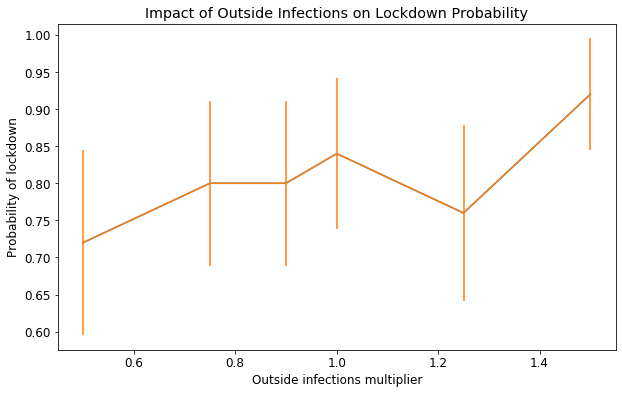

In [46]:
y_err = list()
for result in outside_infections_results:
    y_err.append(1.96 * np.sqrt(result * (1-result)/50))
plt.figure(figsize=(10,6))
plt.plot(sensitivity_multiplication, outside_infections_results)
plt.errorbar(sensitivity_multiplication, outside_infections_results, yerr = y_err)
plt.title('Impact of Outside Infections on Lockdown Probability')
plt.ylabel('Probability of lockdown')
plt.xlabel('Outside infections multiplier')

Initial Prevalence

In [40]:
initial_prevalence_results = list()
for sensitivity_multiplier in sensitivity_multiplication:
    params_list = [ug_dorm_params.copy(), ug_off_campus_params.copy(), gs_research_params.copy(), gs_other_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
    for param in params_list:
        param['initial_ID_prevalence'] *= sensitivity_multiplier
    tests_per_day, sim_results = evaluate_testing_policy(params_list, interaction_matrix, group_names, policy, 84, 50)

    cornell_case_counts = list()
    for sim_dfs in sim_results:
        pre_sim_cases = sample_pre_sim_cases()
        cornell_case_counts.append(np.concatenate([np.array(pre_sim_cases), np.array(get_total_new_cases(sim_dfs, [True, True, True, True, True, True, True, False]))]))

    lockdown_occured = 0
    trajectory = 0
    # 14 day cumulative trajectory
    for new_case_trajectory in cornell_case_counts:
        window_case_trajectory = new_case_trajectory.cumsum()
        window_case_trajectory[14:] = window_case_trajectory[14:] - window_case_trajectory[:-14]
    
        if np.sum(np.array(window_case_trajectory)>100) > 0: # There is a 14 day window with > 100 cases
            lockdown_occured += 1
        trajectory += 1
    initial_prevalence_results.append(lockdown_occured / trajectory)
initial_prevalence_results

[0.32, 0.68, 0.62, 0.84, 0.96, 1.0]

Text(0.5, 0, 'Initial prevalence multiplier')

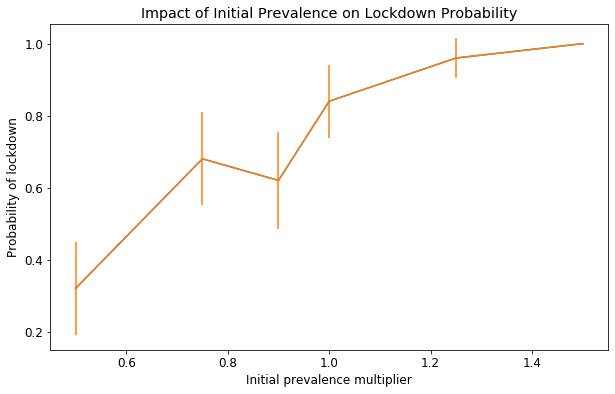

In [47]:
y_err = list()
for result in initial_prevalence_results:
    y_err.append(1.96 * np.sqrt(result * (1-result)/50))
plt.figure(figsize=(10,6))
plt.plot(sensitivity_multiplication, initial_prevalence_results)
plt.errorbar(sensitivity_multiplication, initial_prevalence_results, yerr=y_err)
plt.title('Impact of Initial Prevalence on Lockdown Probability')
plt.ylabel('Probability of lockdown')
plt.xlabel('Initial prevalence multiplier')

Contact Matrix

In [42]:
contact_matrix_results = list()
for sensitivity_multiplier in sensitivity_multiplication:
    params_list = [ug_dorm_params.copy(), ug_off_campus_params.copy(), gs_research_params.copy(), gs_other_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
    tests_per_day, sim_results = evaluate_testing_policy(params_list, sensitivity_multiplier * interaction_matrix, group_names, policy, 84, 50)

    cornell_case_counts = list()
    for sim_dfs in sim_results:
        pre_sim_cases = sample_pre_sim_cases()
        cornell_case_counts.append(np.concatenate([np.array(pre_sim_cases), np.array(get_total_new_cases(sim_dfs, [True, True, True, True, True, True, True, False]))]))

    lockdown_occured = 0
    trajectory = 0
    # 14 day cumulative trajectory
    for new_case_trajectory in cornell_case_counts:
        window_case_trajectory = new_case_trajectory.cumsum()
        window_case_trajectory[14:] = window_case_trajectory[14:] - window_case_trajectory[:-14]
    
        if np.sum(np.array(window_case_trajectory)>100) > 0: # There is a 14 day window with > 100 cases
            lockdown_occured += 1
        trajectory += 1
    contact_matrix_results.append(lockdown_occured / trajectory)
contact_matrix_results

[0.0, 0.06, 0.34, 0.82, 1.0, 1.0]

Text(0.5, 0, 'Contact Rates multiplier')

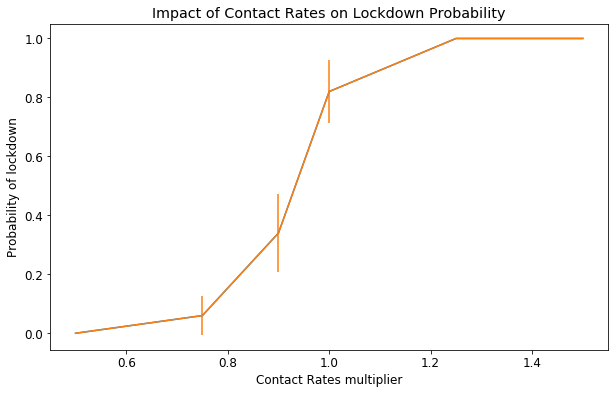

In [49]:
y_err = list()
for result in contact_matrix_results:
    y_err.append(1.96 * np.sqrt(result * (1-result)/50))
plt.figure(figsize=(10,6))
plt.plot(sensitivity_multiplication, contact_matrix_results)
plt.errorbar(sensitivity_multiplication, contact_matrix_results, yerr=y_err)
plt.title('Impact of Contact Rates on Lockdown Probability')
plt.ylabel('Probability of lockdown')
plt.xlabel('Contact Rates multiplier')

# Analysis 2
Remove vet school students (500 not 300) and faculty (850)
Subdivide low-density UGs
Run Sims

In [4]:
base_directory = '../src/simulations_v2/params/baseline_testing/aug_29_NY_lockdown/nominal/'

ug_dorm_params = load_params(base_directory + 'ug_dorm.yaml')[1]
ug_off_campus_params = load_params(base_directory + 'ug_off_campus.yaml')[1]
gs_research_params = load_params(base_directory + 'grad_research.yaml')[1]
gs_other_params = load_params(base_directory + 'grad_other.yaml')[1]
faculty_staff_student_params = load_params(base_directory + 'faculty_staff_student_same_age.yaml')[1]
faculty_staff_non_student_params = load_params(base_directory + 'faculty_staff_non_student_same_age.yaml')[1]
faculty_staff_off_campus_params = load_params(base_directory + 'faculty_staff_off_campus_same_age.yaml')[1]
ithaca_community_params = load_params(base_directory + 'ithaca_community.yaml')[1]

/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Population adjustments

In [5]:
faculty_staff_student_params['population_size'], faculty_staff_non_student_params['population_size'], faculty_staff_off_campus_params['population_size']

(3598, 1907, 4778)

In [6]:
# UG off campus will be dealt with using binomial. For each new UG low case, bernoulli distribution with p=0.67 they will be in the on campus group for NYS threshold

# Vet school: 500 students
gs_other_params['population_size'] = gs_other_params['population_size'] - 500

# Vet school faculty/staff: 850 split amoung the 3 groups (proportionally)
faculty_staff_student_params['population_size'] = faculty_staff_student_params['population_size'] - 297
faculty_staff_non_student_params['population_size'] = faculty_staff_non_student_params['population_size'] - 158
faculty_staff_off_campus_params['population_size'] = faculty_staff_off_campus_params['population_size'] - 395

In [7]:
policy = [2/7,2/7,1/7,2/7,2/7,1/7,1/30,0]
interaction_matrix = np.array([[12.5,4,0.1,0.1,1,0.05,0.05,0.1],
                               [3.41,8,0.1,0.1,1,0.05,0.05,0.2],
                               [0.19,0.22,4,0.1,1.2,0.05,0.2,1.8],
                               [0.14,0.17,0.07,9,1,0.05,0.05,0.2],
                               [1.92,2.26,1.22,1.37,1,0.15,0.3,1.56],
                               [0.18,0.21,0.1,0.13,0.28,1.8,0.2,1.56],
                               [0.07,0.09,0.15,0.05,0.23,0.08,1.8,1.56],
                               [0.011,0.026,0.106,0.016,0.091,0.048,0.12,3.5]])

group_names = ['UG (campus)', 'UG (off campus)', 'GS (research)', 'GS (other)', 'Faculty/Staff (student facing)', 'Faculty/Staff (non student facing)', 'Faculty/Staff (off campus)', 'Ithaca Community']

In [60]:
params_list = [ug_dorm_params.copy(), ug_off_campus_params.copy(), gs_research_params.copy(), gs_other_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
tests_per_day_nominal, sim_results_nominal = evaluate_testing_policy(params_list, interaction_matrix, group_names, policy, 84, 50)

Process UG low new cases

In [8]:
def get_total_new_cases_v2(sim_dfs, include_array):
    assert len(sim_dfs) == len(include_array)
    if include_array[0] == True:
        cases = np.array(sim_dfs[0]['new_cases'])
    else:
        cases = np.array(sim_dfs[0]['new_cases']) - np.array(sim_dfs[0]['new_cases'])
    for i in range(1, len(sim_dfs)):
        if include_array[i] == True:
            if i == 1:
                new_array = list()
                for entry in np.array(sim_dfs[i]['new_cases']):
                    new_array.append(np.random.binomial(entry, 0.67))
                cases += np.array(new_array)
            else:
                cases += np.array(sim_dfs[i]['new_cases'])
    return cases

In [62]:
cornell_case_counts = list()
for sim_dfs in sim_results_nominal:
    pre_sim_cases = sample_pre_sim_cases()
    cornell_case_counts.append(np.concatenate([np.array(pre_sim_cases), np.array(get_total_new_cases_v2(sim_dfs, [True, True, True, True, True, True, True, False]))]))

Text(0.5, 0, 'Day')

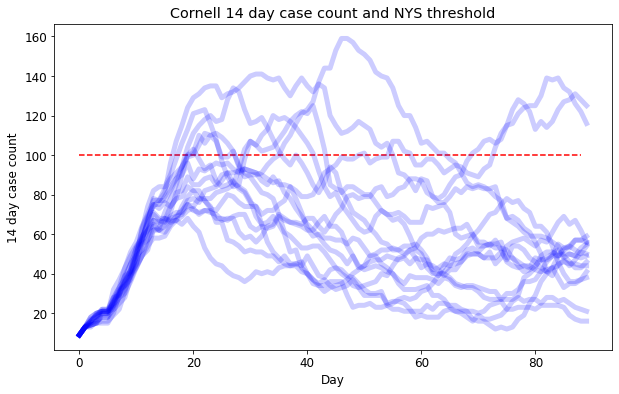

In [63]:
plt.figure(figsize=(10,6))
for new_case_trajectory in cornell_case_counts[:15]:
    window_case_trajectory = new_case_trajectory.cumsum()
    window_case_trajectory[14:] = window_case_trajectory[14:] - window_case_trajectory[:-14]
    plt.plot(window_case_trajectory, color='blue', alpha=0.2, linewidth=5)
plt.hlines(100, 0, 88, colors='red', linestyles='dashed')
plt.title('Cornell 14 day case count and NYS threshold')
plt.ylabel('14 day case count')
plt.xlabel('Day')

In [65]:
lockdown_occured = 0
trajectory = 0
# 14 day cumulative trajectory
for index, new_case_trajectory in enumerate(cornell_case_counts):
    window_case_trajectory = new_case_trajectory.cumsum()
    window_case_trajectory[14:] = window_case_trajectory[14:] - window_case_trajectory[:-14]

    if np.sum(np.array(window_case_trajectory)>100) > 0: # There is a 14 day window with > 100 cases
        lockdown_occured += 1
    else:
        print(index, window_case_trajectory)
    trajectory += 1
print(lockdown_occured / trajectory)

3 [9 13 14 15 19 19 27 33 37 45 53 59 62 70 67 66 71 81 82 89 85 85 88 89 85
 90 91 86 84 82 77 69 65 66 69 65 60 51 52 43 40 37 34 34 36 36 36 29 23
 24 24 25 23 23 24 25 27 28 27 28 31 32 35 39 44 48 47 48 52 53 51 54 55
 53 53 52 48 44 41 42 44 47 48 50 52 48 50 49 48 49]
4 [9 13 16 19 22 22 25 32 34 37 44 49 52 62 62 65 69 71 71 77 78 76 82 83 84
 87 91 91 92 93 92 91 90 88 86 87 81 78 73 69 65 62 59 55 52 51 49 45 49
 43 44 49 49 45 43 40 35 32 32 32 33 34 29 29 27 23 21 21 21 17 16 16 14
 12 13 12 13 17 19 25 29 36 40 43 49 52 54 57 57 59]
5 [9 13 13 16 18 18 22 28 30 36 43 49 54 58 58 59 64 67 69 72 73 70 72 71 70
 67 68 68 61 58 59 56 59 64 65 70 68 66 65 64 62 62 66 69 64 64 61 54 49
 44 42 43 44 43 41 40 37 35 39 38 38 38 37 35 38 37 34 33 34 34 33 32 31
 31 27 30 30 32 36 36 37 41 42 43 44 47 44 47 51 50]
7 [9 13 17 18 22 22 28 33 43 49 54 58 65 71 68 68 67 67 65 68 64 61 53 48 45
 44 41 39 38 36 38 41 40 41 40 43 44 44 44 41 40 37 35 37 34 32 33 34 37
 33 34 35 36 40 39 44 

### Sensitivity Analysis

In [9]:
sensitivity_multiplication = [0.5, 0.75, 0.9, 1, 1.25, 1.5]

##### Outside Infections

In [10]:
outside_infections_results = list()
for sensitivity_multiplier in sensitivity_multiplication:
    params_list = [ug_dorm_params.copy(), ug_off_campus_params.copy(), gs_research_params.copy(), gs_other_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
    for param in params_list:
        param['daily_outside_infection_p'] *= sensitivity_multiplier
    tests_per_day, sim_results = evaluate_testing_policy(params_list, interaction_matrix, group_names, policy, 84, 50)

    cornell_case_counts = list()
    for sim_dfs in sim_results:
        pre_sim_cases = sample_pre_sim_cases()
        cornell_case_counts.append(np.concatenate([np.array(pre_sim_cases), np.array(get_total_new_cases_v2(sim_dfs, [True, True, True, True, True, True, False, False]))]))

    lockdown_occured = 0
    trajectory = 0
    # 14 day cumulative trajectory
    for new_case_trajectory in cornell_case_counts:
        window_case_trajectory = new_case_trajectory.cumsum()
        window_case_trajectory[14:] = window_case_trajectory[14:] - window_case_trajectory[:-14]
    
        if np.sum(np.array(window_case_trajectory)>100) > 0: # There is a 14 day window with > 100 cases
            lockdown_occured += 1
        trajectory += 1
    outside_infections_results.append(lockdown_occured / trajectory)
outside_infections_results

[0.42, 0.5, 0.46, 0.5, 0.6, 0.54]

Text(0.5, 0, 'Outside infections multiplier')

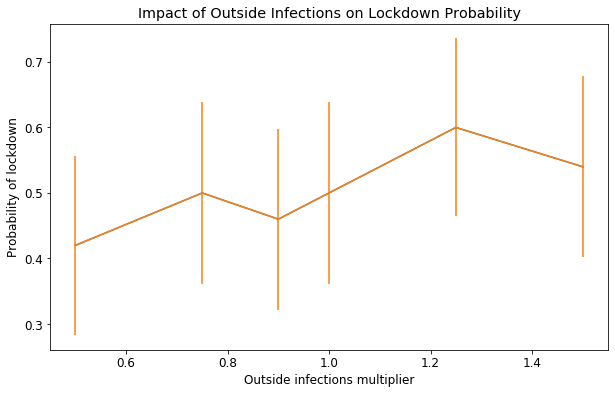

In [11]:
y_err = list()
for result in outside_infections_results:
    y_err.append(1.96 * np.sqrt(result * (1-result)/50))
plt.figure(figsize=(10,6))
plt.plot(sensitivity_multiplication, outside_infections_results)
plt.errorbar(sensitivity_multiplication, outside_infections_results, yerr = y_err)
plt.title('Impact of Outside Infections on Lockdown Probability')
plt.ylabel('Probability of lockdown')
plt.xlabel('Outside infections multiplier')

##### Initial Prevalence

In [12]:
initial_prevalence_results = list()
for sensitivity_multiplier in sensitivity_multiplication:
    params_list = [ug_dorm_params.copy(), ug_off_campus_params.copy(), gs_research_params.copy(), gs_other_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
    for param in params_list:
        param['initial_ID_prevalence'] *= sensitivity_multiplier
    tests_per_day, sim_results = evaluate_testing_policy(params_list, interaction_matrix, group_names, policy, 84, 50)

    cornell_case_counts = list()
    for sim_dfs in sim_results:
        pre_sim_cases = sample_pre_sim_cases()
        cornell_case_counts.append(np.concatenate([np.array(pre_sim_cases), np.array(get_total_new_cases_v2(sim_dfs, [True, True, True, True, True, True, False, False]))]))

    lockdown_occured = 0
    trajectory = 0
    # 14 day cumulative trajectory
    for new_case_trajectory in cornell_case_counts:
        window_case_trajectory = new_case_trajectory.cumsum()
        window_case_trajectory[14:] = window_case_trajectory[14:] - window_case_trajectory[:-14]
    
        if np.sum(np.array(window_case_trajectory)>100) > 0: # There is a 14 day window with > 100 cases
            lockdown_occured += 1
        trajectory += 1
    initial_prevalence_results.append(lockdown_occured / trajectory)
initial_prevalence_results

[0.32, 0.28, 0.46, 0.56, 0.74, 0.94]

Text(0.5, 0, 'Initial prevalence multiplier')

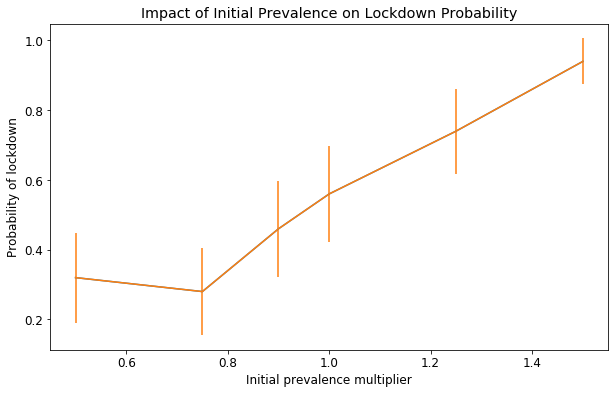

In [13]:
y_err = list()
for result in initial_prevalence_results:
    y_err.append(1.96 * np.sqrt(result * (1-result)/50))
plt.figure(figsize=(10,6))
plt.plot(sensitivity_multiplication, initial_prevalence_results)
plt.errorbar(sensitivity_multiplication, initial_prevalence_results, yerr=y_err)
plt.title('Impact of Initial Prevalence on Lockdown Probability')
plt.ylabel('Probability of lockdown')
plt.xlabel('Initial prevalence multiplier')

##### Contact Matrix

In [14]:
contact_matrix_results = list()
for sensitivity_multiplier in sensitivity_multiplication:
    params_list = [ug_dorm_params.copy(), ug_off_campus_params.copy(), gs_research_params.copy(), gs_other_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
    tests_per_day, sim_results = evaluate_testing_policy(params_list, sensitivity_multiplier * interaction_matrix, group_names, policy, 84, 50)

    cornell_case_counts = list()
    for sim_dfs in sim_results:
        pre_sim_cases = sample_pre_sim_cases()
        cornell_case_counts.append(np.concatenate([np.array(pre_sim_cases), np.array(get_total_new_cases_v2(sim_dfs, [True, True, True, True, True, True, False, False]))]))

    lockdown_occured = 0
    trajectory = 0
    # 14 day cumulative trajectory
    for new_case_trajectory in cornell_case_counts:
        window_case_trajectory = new_case_trajectory.cumsum()
        window_case_trajectory[14:] = window_case_trajectory[14:] - window_case_trajectory[:-14]
    
        if np.sum(np.array(window_case_trajectory)>100) > 0: # There is a 14 day window with > 100 cases
            lockdown_occured += 1
        trajectory += 1
    contact_matrix_results.append(lockdown_occured / trajectory)
contact_matrix_results

[0.0, 0.0, 0.14, 0.62, 1.0, 1.0]

Text(0.5, 0, 'Contact Rates multiplier')

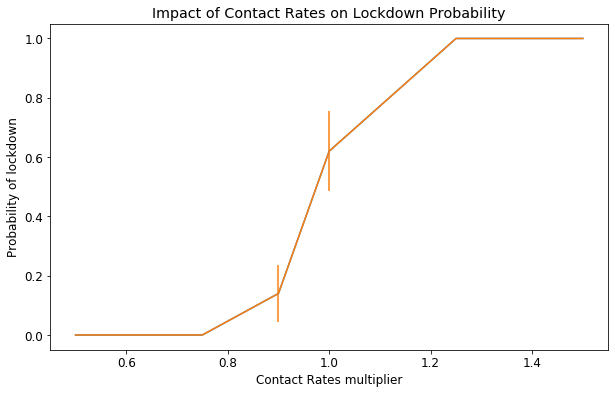

In [15]:
y_err = list()
for result in contact_matrix_results:
    y_err.append(1.96 * np.sqrt(result * (1-result)/50))
plt.figure(figsize=(10,6))
plt.plot(sensitivity_multiplication, contact_matrix_results)
plt.errorbar(sensitivity_multiplication, contact_matrix_results, yerr=y_err)
plt.title('Impact of Contact Rates on Lockdown Probability')
plt.ylabel('Probability of lockdown')
plt.xlabel('Contact Rates multiplier')

### Histogram of time above threshold

In [10]:
def count_time_above_threshold(count_array):
    # 14 day count array
    counts = list()
    current_count = 0
    previous_entry = 0
    for entry in (count_array > 100):
        if (entry == True) and (previous_entry == False):
            current_count = 1
        elif (entry == True) and (previous_entry == True):
            current_count += 1
        elif (entry == False) and (previous_entry == True):
            counts.append(current_count)
        previous_entry = entry
    if (count_array>100)[-1] == True:
        counts.append(current_count)
    print(counts)
    return counts

In [11]:
counts = list()
for new_case_trajectory in cornell_case_counts:
    window_case_trajectory = new_case_trajectory.cumsum()
    window_case_trajectory[14:] = window_case_trajectory[14:] - window_case_trajectory[:-14]
    counts.append(count_time_above_threshold(window_case_trajectory))

[]
[12]
[22]
[73]
[]
[]
[37]
[13]
[38, 1]
[28]
[19, 12]
[19]
[37]
[9, 27]
[7, 40]
[29]
[36]
[54]
[26]
[1]
[5, 1, 25]
[3]
[]
[8]
[25]
[6]
[]
[5, 29, 18]
[2, 1]
[]
[]
[]
[1, 6, 32]
[5, 1, 1, 3, 12, 3, 38]
[14]
[10, 1, 4, 12]
[9, 3]
[9, 1, 15]
[14, 33]
[17, 23, 13]
[39, 13]
[3, 2, 21]
[41, 1, 6]
[1, 9, 2, 18]
[1, 1, 9, 14]
[]
[10, 1, 3, 4]
[]
[13]
[]


In [12]:
counts = np.concatenate(counts)

Text(0.5, 0, 'Consecutive Days above Threshold')

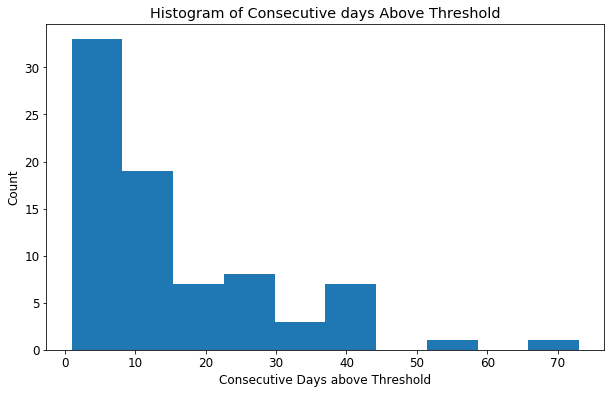

In [15]:
plt.figure(figsize=(10,6))
plt.hist(counts)
plt.title('Histogram of Consecutive days Above Threshold')
plt.ylabel('Count')
plt.xlabel('Consecutive Days above Threshold')

## Refined Counting of contacts per day (for NYS threshold)

In [5]:
def get_total_new_cases_v3(sim_dfs, include_array):
    assert len(sim_dfs) == len(include_array)
    if include_array[0] > 0:
        new_array = list()
        for entry in np.array(sim_dfs[0]['new_cases']):
            new_array.append(np.random.binomial(entry, include_array[0]))
        cases = np.array(new_array)
    else:
        cases = np.array(sim_dfs[0]['new_cases']) - np.array(sim_dfs[0]['new_cases'])
    for i in range(1, len(sim_dfs)):
        if include_array[i] > 0:
            new_array = list()
            for entry in np.array(sim_dfs[i]['new_cases']):
                new_array.append(np.random.binomial(entry, include_array[i]))
            cases += np.array(new_array)
    return cases

In [10]:
def sample_pre_sim_cases():
    pre_sim_cases = list()
    pre_sim_cases.append(3) # August 28 (9)
    pre_sim_cases.append(1) # August 29 (2)
    pre_sim_cases.append(1) # August 30 (1)
    pre_sim_cases.append(2) # August 31 (5)
    pre_sim_cases.append(2) # Sept 1 (7)
    pre_sim_cases.append(7) # Sept 2 (19)
    return pre_sim_cases

In [33]:
base_directory = '../src/simulations_v2/params/baseline_testing/aug_29_NY_lockdown/nominal/'

ug_dorm_params = load_params(base_directory + 'ug_dorm.yaml')[1]
ug_off_campus_params = load_params(base_directory + 'ug_off_campus.yaml')[1]
gs_research_params = load_params(base_directory + 'grad_research.yaml')[1]
gs_other_params = load_params(base_directory + 'grad_other.yaml')[1]
faculty_staff_student_params = load_params(base_directory + 'faculty_staff_student_same_age.yaml')[1]
faculty_staff_non_student_params = load_params(base_directory + 'faculty_staff_non_student_same_age.yaml')[1]
faculty_staff_off_campus_params = load_params(base_directory + 'faculty_staff_off_campus_same_age.yaml')[1]
ithaca_community_params = load_params(base_directory + 'ithaca_community.yaml')[1]

/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


Population adjustments

In [20]:
faculty_staff_student_params['population_size'], faculty_staff_non_student_params['population_size'], faculty_staff_off_campus_params['population_size']

(3301, 1749, 4383)

In [8]:
policy = [2/7,2/7,1/7,2/7,2/7,1/7,1/30,0]
interaction_matrix = np.array([[12.5,4,0.1,0.1,1,0.05,0.05,0.1],
                               [3.41,8,0.1,0.1,1,0.05,0.05,0.2],
                               [0.19,0.22,4,0.1,1.2,0.05,0.2,1.8],
                               [0.14,0.17,0.07,9,1,0.05,0.05,0.2],
                               [1.92,2.26,1.22,1.37,1,0.15,0.3,1.56],
                               [0.18,0.21,0.1,0.13,0.28,1.8,0.2,1.56],
                               [0.07,0.09,0.15,0.05,0.23,0.08,1.8,1.56],
                               [0.011,0.026,0.106,0.016,0.091,0.048,0.12,3.5]])

group_names = ['UG (campus)', 'UG (off campus)', 'GS (research)', 'GS (other)', 'Faculty/Staff (student facing)', 'Faculty/Staff (non student facing)', 'Faculty/Staff (off campus)', 'Ithaca Community']

In [34]:
# UG off campus will be dealt with using binomial. For each new UG low case, bernoulli distribution with p=0.67 they will be in the on campus group for NYS threshold

# Vet school: 500 students
gs_other_params['population_size'] = gs_other_params['population_size'] - 500

# Vet school faculty/staff: 850 split amoung the 3 groups (proportionally)
faculty_staff_student_params['population_size'] = faculty_staff_student_params['population_size'] - 297
faculty_staff_non_student_params['population_size'] = faculty_staff_non_student_params['population_size'] - 158
faculty_staff_off_campus_params['population_size'] = faculty_staff_off_campus_params['population_size'] - 395


# Law school: 469 students
gs_other_params['population_size'] = gs_other_params['population_size'] - 469

# Law school faculty/staff: 130 split amoung the 3 groups (proportionally)
faculty_staff_student_params['population_size'] = faculty_staff_student_params['population_size'] - 45
faculty_staff_non_student_params['population_size'] = faculty_staff_non_student_params['population_size'] - 24
faculty_staff_off_campus_params['population_size'] = faculty_staff_off_campus_params['population_size'] - 61


In [36]:
params_list = [ug_dorm_params.copy(), ug_off_campus_params.copy(), gs_research_params.copy(), gs_other_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
no_law_vet_tests_per_day_nominal, no_law_vet_sim_results_nominal = evaluate_testing_policy(params_list, interaction_matrix, group_names, policy, 84, 50)

In [11]:
# Define include array
include_array = [1, 0.67, 0.67, 0.67, 1, 1, 0, 0]
# vet students: 500, vet f/s: 850
# law students: 469, law f/s: 130

# total_fs = faculty_staff_student_params['population_size'] + faculty_staff_non_student_params['population_size'] + faculty_staff_off_campus_params['population_size']
# vet_include_array = [1, 0.67, 0.67, (0.67 * gs_other_params['population_size'] - 469)/gs_other_params['population_size'], (total_fs-130)/total_fs]
# law_include_array = []
# no_vet_law_include_array = []

#### Results for including vet + law

In [13]:
cornell_case_counts = list()
for sim_dfs in sim_results_nominal:
    pre_sim_cases = sample_pre_sim_cases()
    cornell_case_counts.append(np.concatenate([np.array(pre_sim_cases), np.array(get_total_new_cases_v3(sim_dfs, include_array))]))

Text(0.5, 0, 'Day')

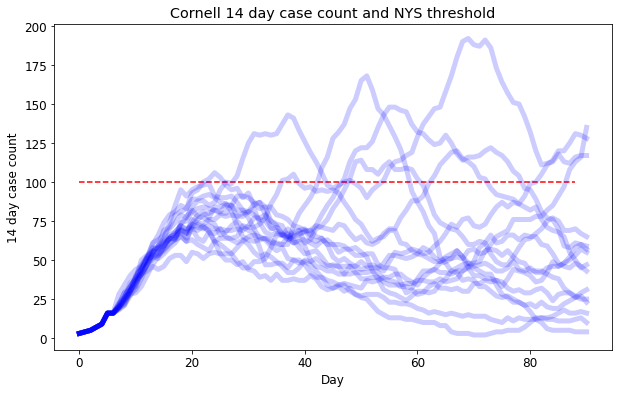

In [18]:
plt.figure(figsize=(10,6))
for new_case_trajectory in cornell_case_counts[:15]:
    window_case_trajectory = new_case_trajectory.cumsum()
    window_case_trajectory[14:] = window_case_trajectory[14:] - window_case_trajectory[:-14]
    plt.plot(window_case_trajectory, color='blue', alpha=0.2, linewidth=5)
plt.hlines(100, 0, 88, colors='red', linestyles='dashed')
plt.title('Cornell 14 day case count and NYS threshold')
plt.ylabel('14 day case count')
plt.xlabel('Day')

In [16]:
lockdown_occured = 0
trajectory = 0
# 14 day cumulative trajectory
for index, new_case_trajectory in enumerate(cornell_case_counts):
    window_case_trajectory = new_case_trajectory.cumsum()
    window_case_trajectory[14:] = window_case_trajectory[14:] - window_case_trajectory[:-14]

    if np.sum(np.array(window_case_trajectory)>100) > 0: # There is a 14 day window with > 100 cases
        lockdown_occured += 1
#     else:
#         print(index, window_case_trajectory)
    trajectory += 1
print(lockdown_occured / trajectory)

0.46


#### Results for excluding vet (including law)

In [24]:
no_vet_case_counts = list()
for sim_dfs in no_vet_sim_results_nominal:
    pre_sim_cases = sample_pre_sim_cases()
    no_vet_case_counts.append(np.concatenate([np.array(pre_sim_cases), np.array(get_total_new_cases_v3(sim_dfs, include_array))]))

Text(0.5, 0, 'Day')

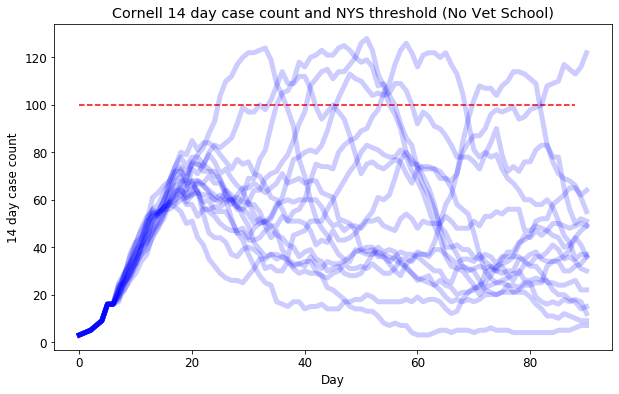

In [25]:
plt.figure(figsize=(10,6))
for new_case_trajectory in no_vet_case_counts[:15]:
    window_case_trajectory = new_case_trajectory.cumsum()
    window_case_trajectory[14:] = window_case_trajectory[14:] - window_case_trajectory[:-14]
    plt.plot(window_case_trajectory, color='blue', alpha=0.2, linewidth=5)
plt.hlines(100, 0, 88, colors='red', linestyles='dashed')
plt.title('Cornell 14 day case count and NYS threshold (No Vet School)')
plt.ylabel('14 day case count')
plt.xlabel('Day')

In [26]:
lockdown_occured = 0
trajectory = 0
# 14 day cumulative trajectory
for index, new_case_trajectory in enumerate(no_vet_case_counts):
    window_case_trajectory = new_case_trajectory.cumsum()
    window_case_trajectory[14:] = window_case_trajectory[14:] - window_case_trajectory[:-14]

    if np.sum(np.array(window_case_trajectory)>100) > 0: # There is a 14 day window with > 100 cases
        lockdown_occured += 1
#     else:
#         print(index, window_case_trajectory)
    trajectory += 1
print(lockdown_occured / trajectory)

0.48


#### Results for excluding law (including vet)

In [30]:
no_law_case_counts = list()
for sim_dfs in no_vet_sim_results_nominal:
    pre_sim_cases = sample_pre_sim_cases()
    no_law_case_counts.append(np.concatenate([np.array(pre_sim_cases), np.array(get_total_new_cases_v3(sim_dfs, include_array))]))

Text(0.5, 0, 'Day')

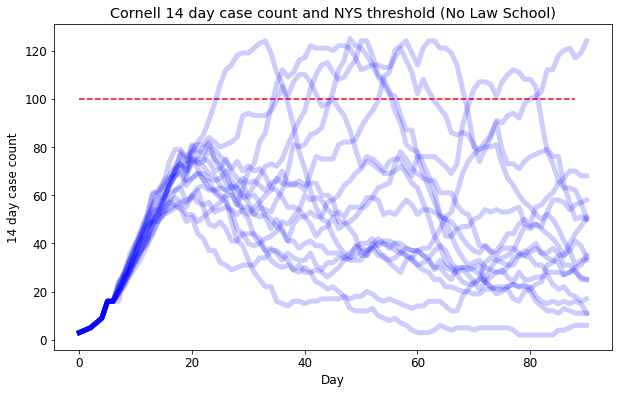

In [31]:
plt.figure(figsize=(10,6))
for new_case_trajectory in no_law_case_counts[:15]:
    window_case_trajectory = new_case_trajectory.cumsum()
    window_case_trajectory[14:] = window_case_trajectory[14:] - window_case_trajectory[:-14]
    plt.plot(window_case_trajectory, color='blue', alpha=0.2, linewidth=5)
plt.hlines(100, 0, 88, colors='red', linestyles='dashed')
plt.title('Cornell 14 day case count and NYS threshold (No Law School)')
plt.ylabel('14 day case count')
plt.xlabel('Day')

In [32]:
lockdown_occured = 0
trajectory = 0
# 14 day cumulative trajectory
for index, new_case_trajectory in enumerate(no_law_case_counts):
    window_case_trajectory = new_case_trajectory.cumsum()
    window_case_trajectory[14:] = window_case_trajectory[14:] - window_case_trajectory[:-14]

    if np.sum(np.array(window_case_trajectory)>100) > 0: # There is a 14 day window with > 100 cases
        lockdown_occured += 1
#     else:
#         print(index, window_case_trajectory)
    trajectory += 1
print(lockdown_occured / trajectory)

0.5


#### No law or vet school

In [37]:
no_law_vet_case_counts = list()
for sim_dfs in no_vet_sim_results_nominal:
    pre_sim_cases = sample_pre_sim_cases()
    no_law_vet_case_counts.append(np.concatenate([np.array(pre_sim_cases), np.array(get_total_new_cases_v3(sim_dfs, include_array))]))

Text(0.5, 0, 'Day')

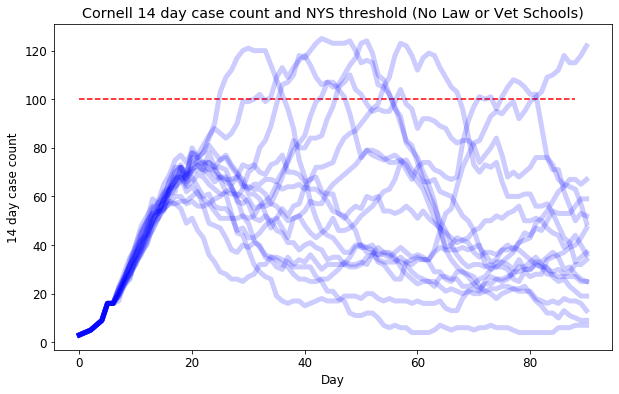

In [38]:
plt.figure(figsize=(10,6))
for new_case_trajectory in no_law_vet_case_counts[:15]:
    window_case_trajectory = new_case_trajectory.cumsum()
    window_case_trajectory[14:] = window_case_trajectory[14:] - window_case_trajectory[:-14]
    plt.plot(window_case_trajectory, color='blue', alpha=0.2, linewidth=5)
plt.hlines(100, 0, 88, colors='red', linestyles='dashed')
plt.title('Cornell 14 day case count and NYS threshold (No Law or Vet Schools)')
plt.ylabel('14 day case count')
plt.xlabel('Day')

In [39]:
lockdown_occured = 0
trajectory = 0
# 14 day cumulative trajectory
for index, new_case_trajectory in enumerate(no_law_vet_case_counts):
    window_case_trajectory = new_case_trajectory.cumsum()
    window_case_trajectory[14:] = window_case_trajectory[14:] - window_case_trajectory[:-14]

    if np.sum(np.array(window_case_trajectory)>100) > 0: # There is a 14 day window with > 100 cases
        lockdown_occured += 1
#     else:
#         print(index, window_case_trajectory)
    trajectory += 1
print(lockdown_occured / trajectory)

0.46


## Sept 4 Runs (note that initial prevalance params have been updated)

In [3]:
def sample_pre_sim_cases():
    pre_sim_cases = list()
    pre_sim_cases.append(4) # Sept 2
    pre_sim_cases.append(15) # Sept 3
    pre_sim_cases.append(4) # Sept 4
    pre_sim_cases.append(4) # Sept 5
    pre_sim_cases.append(4) # Sept 6
    return pre_sim_cases

In [4]:
base_directory = '../src/simulations_v2/params/baseline_testing/aug_29_NY_lockdown/nominal/'

ug_dorm_params = load_params(base_directory + 'ug_dorm.yaml')[1]
ug_off_campus_params = load_params(base_directory + 'ug_off_campus.yaml')[1]
gs_research_params = load_params(base_directory + 'grad_research.yaml')[1]
gs_other_params = load_params(base_directory + 'grad_other.yaml')[1]
faculty_staff_student_params = load_params(base_directory + 'faculty_staff_student_same_age.yaml')[1]
faculty_staff_non_student_params = load_params(base_directory + 'faculty_staff_non_student_same_age.yaml')[1]
faculty_staff_off_campus_params = load_params(base_directory + 'faculty_staff_off_campus_same_age.yaml')[1]
ithaca_community_params = load_params(base_directory + 'ithaca_community.yaml')[1]

/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


In [5]:
policy = [2/7,2/7,1/7,1/7,1/7,1/7,1/30,0]
interaction_matrix = np.array([[12.5,4,0.1,0.1,1,0.05,0.05,0.1],
                               [3.41,8,0.1,0.1,1,0.05,0.05,0.2],
                               [0.19,0.22,4,0.1,1.2,0.05,0.2,1.8],
                               [0.14,0.17,0.07,9,1,0.05,0.05,0.2],
                               [1.92,2.26,1.22,1.37,1,0.15,0.3,1.56],
                               [0.18,0.21,0.1,0.13,0.28,1.8,0.2,1.56],
                               [0.07,0.09,0.15,0.05,0.23,0.08,1.8,1.56],
                               [0.011,0.026,0.106,0.016,0.091,0.048,0.12,3.5]])

group_names = ['UG (campus)', 'UG (off campus)', 'GS (research)', 'GS (other)', 'Faculty/Staff (student facing)', 'Faculty/Staff (non student facing)', 'Faculty/Staff (off campus)', 'Ithaca Community']

In [6]:
def get_total_new_cases_v3(sim_dfs, include_array):
    assert len(sim_dfs) == len(include_array)
    if include_array[0] > 0:
        new_array = list()
        for entry in np.array(sim_dfs[0]['new_cases']):
            new_array.append(np.random.binomial(entry, include_array[0]))
        cases = np.array(new_array)
    else:
        cases = np.array(sim_dfs[0]['new_cases']) - np.array(sim_dfs[0]['new_cases'])
    for i in range(1, len(sim_dfs)):
        if include_array[i] > 0:
            new_array = list()
            for entry in np.array(sim_dfs[i]['new_cases']):
                new_array.append(np.random.binomial(entry, include_array[i]))
            cases += np.array(new_array)
    return cases

#### All students included

In [7]:
params_list = [ug_dorm_params.copy(), ug_off_campus_params.copy(), gs_research_params.copy(), gs_other_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
tests_per_day_nominal, sim_results_nominal = evaluate_testing_policy(params_list, interaction_matrix, group_names, policy, 84, 100)

In [8]:
# Define include array
include_array = [1, 0.67, 0.67, 0.67, 1, 1, 0, 0]

In [9]:
cornell_case_counts = list()
for sim_dfs in sim_results_nominal:
    pre_sim_cases = sample_pre_sim_cases()
    cornell_case_counts.append(np.concatenate([np.array(pre_sim_cases), np.array(get_total_new_cases_v3(sim_dfs, include_array))]))

Text(0.5, 0, 'Day')

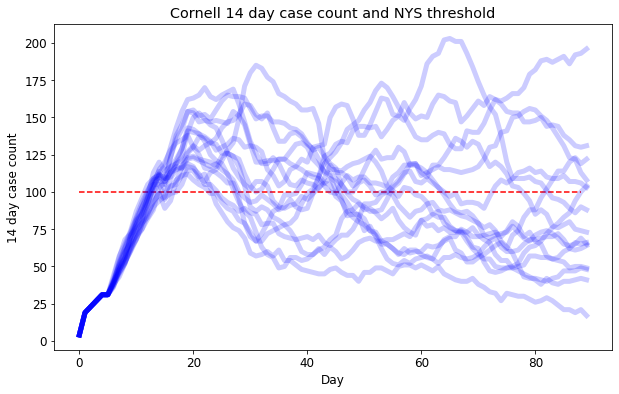

In [10]:
plt.figure(figsize=(10,6))
for new_case_trajectory in cornell_case_counts[:15]:
    window_case_trajectory = new_case_trajectory.cumsum()
    window_case_trajectory[14:] = window_case_trajectory[14:] - window_case_trajectory[:-14]
    plt.plot(window_case_trajectory, color='blue', alpha=0.2, linewidth=5)
plt.hlines(100, 0, 88, colors='red', linestyles='dashed')
plt.title('Cornell 14 day case count and NYS threshold')
plt.ylabel('14 day case count')
plt.xlabel('Day')

In [11]:
lockdown_occured = 0
trajectory = 0
time_hit_trajectory = list()
# 14 day cumulative trajectory
for index, new_case_trajectory in enumerate(cornell_case_counts):
    window_case_trajectory = new_case_trajectory.cumsum()
    window_case_trajectory[14:] = window_case_trajectory[14:] - window_case_trajectory[:-14]

    if np.sum(np.array(window_case_trajectory)>100) > 0: # There is a 14 day window with > 100 cases
        lockdown_occured += 1
        time_hit_trajectory.append(np.nonzero(np.array(window_case_trajectory)>100)[0][0])
#     else:
#         print(index, window_case_trajectory)
    trajectory += 1
print(lockdown_occured / trajectory)

0.99


In [12]:
np.median(time_hit_trajectory)

13.0

#### Excluding Vet School

In [12]:
base_directory = '../src/simulations_v2/params/baseline_testing/aug_29_NY_lockdown/nominal/'

ug_dorm_params = load_params(base_directory + 'ug_dorm.yaml')[1]
ug_off_campus_params = load_params(base_directory + 'ug_off_campus.yaml')[1]
gs_research_params = load_params(base_directory + 'grad_research.yaml')[1]
gs_other_params = load_params(base_directory + 'grad_other.yaml')[1]
faculty_staff_student_params = load_params(base_directory + 'faculty_staff_student_same_age.yaml')[1]
faculty_staff_non_student_params = load_params(base_directory + 'faculty_staff_non_student_same_age.yaml')[1]
faculty_staff_off_campus_params = load_params(base_directory + 'faculty_staff_off_campus_same_age.yaml')[1]
ithaca_community_params = load_params(base_directory + 'ithaca_community.yaml')[1]

/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


In [13]:
# UG off campus will be dealt with using binomial. For each new UG low case, bernoulli distribution with p=0.67 they will be in the on campus group for NYS threshold

# Vet school: 500 students
gs_other_params['population_size'] = gs_other_params['population_size'] - 500

# Vet school faculty/staff: 850 split amoung the 3 groups (proportionally)
faculty_staff_student_params['population_size'] = faculty_staff_student_params['population_size'] - 297
faculty_staff_non_student_params['population_size'] = faculty_staff_non_student_params['population_size'] - 158
faculty_staff_off_campus_params['population_size'] = faculty_staff_off_campus_params['population_size'] - 395

In [14]:
params_list = [ug_dorm_params.copy(), ug_off_campus_params.copy(), gs_research_params.copy(), gs_other_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
no_vet_tests_per_day_nominal, no_vet_sim_results_nominal = evaluate_testing_policy(params_list, interaction_matrix, group_names, policy, 84, 50)

In [15]:
no_vet_case_counts = list()
for sim_dfs in no_vet_sim_results_nominal:
    pre_sim_cases = sample_pre_sim_cases()
    no_vet_case_counts.append(np.concatenate([np.array(pre_sim_cases), np.array(get_total_new_cases_v3(sim_dfs, include_array))]))

Text(0.5, 0, 'Day')

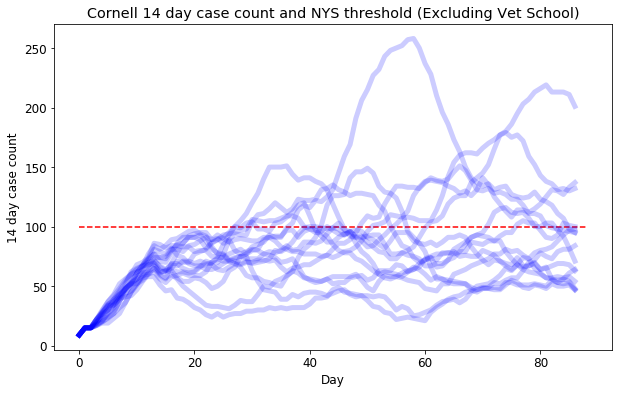

In [16]:
plt.figure(figsize=(10,6))
for new_case_trajectory in no_vet_case_counts[:15]:
    window_case_trajectory = new_case_trajectory.cumsum()
    window_case_trajectory[14:] = window_case_trajectory[14:] - window_case_trajectory[:-14]
    plt.plot(window_case_trajectory, color='blue', alpha=0.2, linewidth=5)
plt.hlines(100, 0, 88, colors='red', linestyles='dashed')
plt.title('Cornell 14 day case count and NYS threshold (Excluding Vet School)')
plt.ylabel('14 day case count')
plt.xlabel('Day')

In [17]:
lockdown_occured = 0
trajectory = 0
# 14 day cumulative trajectory
for index, new_case_trajectory in enumerate(no_vet_case_counts):
    window_case_trajectory = new_case_trajectory.cumsum()
    window_case_trajectory[14:] = window_case_trajectory[14:] - window_case_trajectory[:-14]

    if np.sum(np.array(window_case_trajectory)>100) > 0: # There is a 14 day window with > 100 cases
        lockdown_occured += 1
#     else:
#         print(index, window_case_trajectory)
    trajectory += 1
print(lockdown_occured / trajectory)

0.56


#### Excluding Law School

In [18]:
base_directory = '../src/simulations_v2/params/baseline_testing/aug_29_NY_lockdown/nominal/'

ug_dorm_params = load_params(base_directory + 'ug_dorm.yaml')[1]
ug_off_campus_params = load_params(base_directory + 'ug_off_campus.yaml')[1]
gs_research_params = load_params(base_directory + 'grad_research.yaml')[1]
gs_other_params = load_params(base_directory + 'grad_other.yaml')[1]
faculty_staff_student_params = load_params(base_directory + 'faculty_staff_student_same_age.yaml')[1]
faculty_staff_non_student_params = load_params(base_directory + 'faculty_staff_non_student_same_age.yaml')[1]
faculty_staff_off_campus_params = load_params(base_directory + 'faculty_staff_off_campus_same_age.yaml')[1]
ithaca_community_params = load_params(base_directory + 'ithaca_community.yaml')[1]

/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


In [19]:
# Law school: 469 students
gs_other_params['population_size'] = gs_other_params['population_size'] - 469

# Law school faculty/staff: 130 split amoung the 3 groups (proportionally)
faculty_staff_student_params['population_size'] = faculty_staff_student_params['population_size'] - 45
faculty_staff_non_student_params['population_size'] = faculty_staff_non_student_params['population_size'] - 24
faculty_staff_off_campus_params['population_size'] = faculty_staff_off_campus_params['population_size'] - 61

In [20]:
params_list = [ug_dorm_params.copy(), ug_off_campus_params.copy(), gs_research_params.copy(), gs_other_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
no_law_tests_per_day_nominal, no_law_sim_results_nominal = evaluate_testing_policy(params_list, interaction_matrix, group_names, policy, 84, 50)

In [21]:
no_law_case_counts = list()
for sim_dfs in no_law_sim_results_nominal:
    pre_sim_cases = sample_pre_sim_cases()
    no_law_case_counts.append(np.concatenate([np.array(pre_sim_cases), np.array(get_total_new_cases_v3(sim_dfs, include_array))]))

Text(0.5, 0, 'Day')

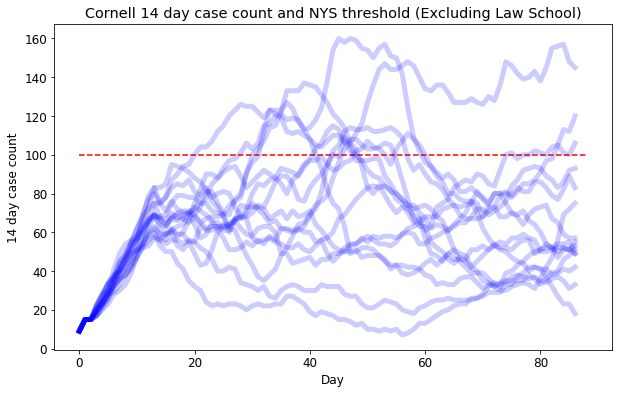

In [22]:
plt.figure(figsize=(10,6))
for new_case_trajectory in no_law_case_counts[:15]:
    window_case_trajectory = new_case_trajectory.cumsum()
    window_case_trajectory[14:] = window_case_trajectory[14:] - window_case_trajectory[:-14]
    plt.plot(window_case_trajectory, color='blue', alpha=0.2, linewidth=5)
plt.hlines(100, 0, 88, colors='red', linestyles='dashed')
plt.title('Cornell 14 day case count and NYS threshold (Excluding Law School)')
plt.ylabel('14 day case count')
plt.xlabel('Day')

In [23]:
lockdown_occured = 0
trajectory = 0
# 14 day cumulative trajectory
for index, new_case_trajectory in enumerate(no_law_case_counts):
    window_case_trajectory = new_case_trajectory.cumsum()
    window_case_trajectory[14:] = window_case_trajectory[14:] - window_case_trajectory[:-14]

    if np.sum(np.array(window_case_trajectory)>100) > 0: # There is a 14 day window with > 100 cases
        lockdown_occured += 1
#     else:
#         print(index, window_case_trajectory)
    trajectory += 1
print(lockdown_occured / trajectory)

0.72


#### Excluding Law and Vet Schools 

In [36]:
base_directory = '../src/simulations_v2/params/baseline_testing/aug_29_NY_lockdown/nominal/'

ug_dorm_params = load_params(base_directory + 'ug_dorm.yaml')[1]
ug_off_campus_params = load_params(base_directory + 'ug_off_campus.yaml')[1]
gs_research_params = load_params(base_directory + 'grad_research.yaml')[1]
gs_other_params = load_params(base_directory + 'grad_other.yaml')[1]
faculty_staff_student_params = load_params(base_directory + 'faculty_staff_student_same_age.yaml')[1]
faculty_staff_non_student_params = load_params(base_directory + 'faculty_staff_non_student_same_age.yaml')[1]
faculty_staff_off_campus_params = load_params(base_directory + 'faculty_staff_off_campus_same_age.yaml')[1]
ithaca_community_params = load_params(base_directory + 'ithaca_community.yaml')[1]

/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


In [37]:
# UG off campus will be dealt with using binomial. For each new UG low case, bernoulli distribution with p=0.67 they will be in the on campus group for NYS threshold

# Vet school: 500 students
gs_other_params['population_size'] = gs_other_params['population_size'] - 500

# Vet school faculty/staff: 850 split amoung the 3 groups (proportionally)
faculty_staff_student_params['population_size'] = faculty_staff_student_params['population_size'] - 297
faculty_staff_non_student_params['population_size'] = faculty_staff_non_student_params['population_size'] - 158
faculty_staff_off_campus_params['population_size'] = faculty_staff_off_campus_params['population_size'] - 395


# Law school: 469 students
gs_other_params['population_size'] = gs_other_params['population_size'] - 469

# Law school faculty/staff: 130 split amoung the 3 groups (proportionally)
faculty_staff_student_params['population_size'] = faculty_staff_student_params['population_size'] - 45
faculty_staff_non_student_params['population_size'] = faculty_staff_non_student_params['population_size'] - 24
faculty_staff_off_campus_params['population_size'] = faculty_staff_off_campus_params['population_size'] - 61


In [38]:
params_list = [ug_dorm_params.copy(), ug_off_campus_params.copy(), gs_research_params.copy(), gs_other_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
no_law_vet_tests_per_day_nominal, no_law_vet_sim_results_nominal = evaluate_testing_policy(params_list, interaction_matrix, group_names, policy, 84, 50)

In [39]:
no_law_vet_case_counts = list()
for sim_dfs in no_law_vet_sim_results_nominal:
    pre_sim_cases = sample_pre_sim_cases()
    no_law_vet_case_counts.append(np.concatenate([np.array(pre_sim_cases), np.array(get_total_new_cases_v3(sim_dfs, include_array))]))

Text(0.5, 0, 'Day')

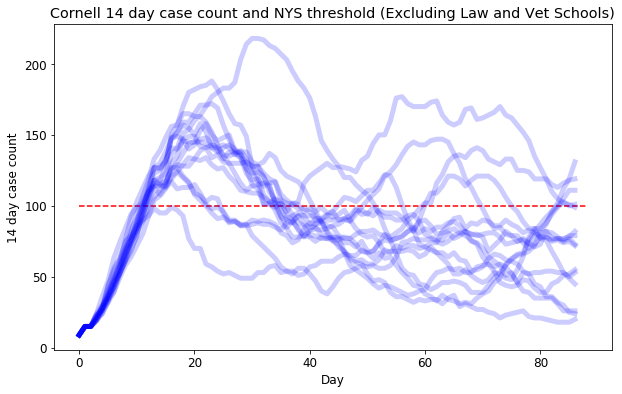

In [40]:
plt.figure(figsize=(10,6))
for new_case_trajectory in no_law_vet_case_counts[:15]:
    window_case_trajectory = new_case_trajectory.cumsum()
    window_case_trajectory[14:] = window_case_trajectory[14:] - window_case_trajectory[:-14]
    plt.plot(window_case_trajectory, color='blue', alpha=0.2, linewidth=5)
plt.hlines(100, 0, 88, colors='red', linestyles='dashed')
plt.title('Cornell 14 day case count and NYS threshold (Excluding Law and Vet Schools)')
plt.ylabel('14 day case count')
plt.xlabel('Day')

In [41]:
lockdown_occured = 0
trajectory = 0
# 14 day cumulative trajectory
for index, new_case_trajectory in enumerate(no_law_vet_case_counts):
    window_case_trajectory = new_case_trajectory.cumsum()
    window_case_trajectory[14:] = window_case_trajectory[14:] - window_case_trajectory[:-14]

    if np.sum(np.array(window_case_trajectory)>100) > 0: # There is a 14 day window with > 100 cases
        lockdown_occured += 1
#     else:
#         print(index, window_case_trajectory)
    trajectory += 1
print(lockdown_occured / trajectory)

0.94
